Rename a bunch of files using Git and renamer?



In [ ]:
var execSync = require('child_process').execSync;
try {
    require.resolve('renamer');
} catch (e) {
    execSync('npm install renamer');
}
var renamer = require('renamer');
var renameUsingGit = (root, match, find, replace) => {
    var files = renamer.expand(path.join(root, match));
    var results = renamer.replace({
        files: files.filesAndDirs, 
        find: find, 
        replace: replace});
    return renamer.dryRun(results).list.map(r => {
        // rename with git instead
        var output = execSync('git ' 
                 + '--work-tree=' + JSON.stringify(root)
                 + ' --git-dir=' + JSON.stringify(path.join(root, '.git'))
                 + ' mv ' + JSON.stringify(r.before) 
                 + ' ' + JSON.stringify(r.after));
        return output.toString() || r.after;
    });
};
renameUsingGit;


In [ ]:
// test it
// rename all scss files to less
//renameUsingGit(
//    '/Users/briancullinan/Documents/portal',
//    'src/**/*.scss',
//    '.scss',
//    '.less');

How to use memory-fs and rewire to audit cli events?



In [ ]:
var path = require('path');
var execSync = require('child_process').execSync;
try {
    require.resolve('mock-require');
    require.resolve('unionfs');
    require.resolve('typescript');
    require.resolve('memfs');
} catch (e) {
    execSync('npm install mock-require memfs typescript unionfs');
}
// TODO: use https://github.com/jhnns/rewire for replacing variables, something like https://github.com/mariocasciaro/object-path?

var mockTypescriptFs = (root, data) => {
    var mock = require('mock-require');
    var memfs = require('memfs');
    var mem = new memfs.Volume;
    var unionfs = require('unionfs');
    var fs = require('fs');
    
    mem.mountSync(root, data);

    // Create a union of two file systems:
    unionfs
        .use(fs)
        .use(mem)
        .replace(fs);
    
    var ts = require('typescript');
    var tsMock = Object.assign({}, ts);
    var toMock = {
        readFile: 'readFileSync',
        realpath: 'realpathSync',
        writeFile: 'writeFileSync',
        fileExists: 'existsSync',
        directoryExists: 'existsSync',
        createDirectory: 'mkdirSync',
        getDirectories: 'readdirSync'
    };
    Object.keys(toMock)
        .forEach(k => {
            if(typeof mem[toMock[k]] === 'function') {
                tsMock.sys[k] = function () {
                    // typescript.sys functions return defined on error
                    try {
                        return mem[toMock[k]].apply(mem, arguments);
                    } catch (e) {
                        return;
                    }
                };
            }
        });

    mock('typescript', tsMock);
    return mock;
};
mockTypescriptFs;

// TODO: search github for projects like graceful-fs and then search google for projects that use graceful-fs and see if we can record some filesystem activity



In [ ]:

//mockTypescriptFs();


Parse typescript includes for an entire project and display it as a word-cloud?



In [1]:
var importer = require('../Core');
var path = require('path');
var execSync = require('child_process').execSync;
try {
    require.resolve('gulp');
    require.resolve('gulp-tap');
} catch (e) {
    execSync('npm install "github:gulpjs/gulp.git#4.0" gulp-tap');
}
var gulp = require('gulp');
var tap = require('gulp-tap');

var projectWordCloud = (project) => {
    var words = [];
    
    var wordCount = function (words) {
        var wordCount = {};
        words.forEach(w => {
            if(typeof wordCount[w] == 'undefined') {
                wordCount[w] = 15;
            } else {
                wordCount[w]++;
            }
        });
        return Object.keys(wordCount).map((d) => ({text: d, size: wordCount[d]}));
    };
    
    return importer.interpretAll([
            'relative paths and includes'
        ])
        .then(r => r[0].runInNewContext({project}))
        .then(r => r(project))
        .then(r => {
            words = r['packages'].map(p => p.split('.ts/')[1]).concat(r['relatives'].map(r => path.basename(r)));
        })
        .then(() => importer.importNotebook('../Frameworks/d3.ipynb'))
        .then(r => {
            var d3CloudToSVG = r.d3CloudToSVG;
            return d3CloudToSVG(wordCount(words));
        });
};
projectWordCloud;



[Function: projectWordCloud]

Already imported
[ 'import notebook.ipynb',
  'interpret all notebooks.ipynb',
  'd3.ipynb' ]
Already imported
[ 'import notebook.ipynb',
  'interpret all notebooks.ipynb',
  'd3.ipynb' ]
Already imported
[ 'import notebook.ipynb',
  'interpret all notebooks.ipynb',
  'd3.ipynb' ]


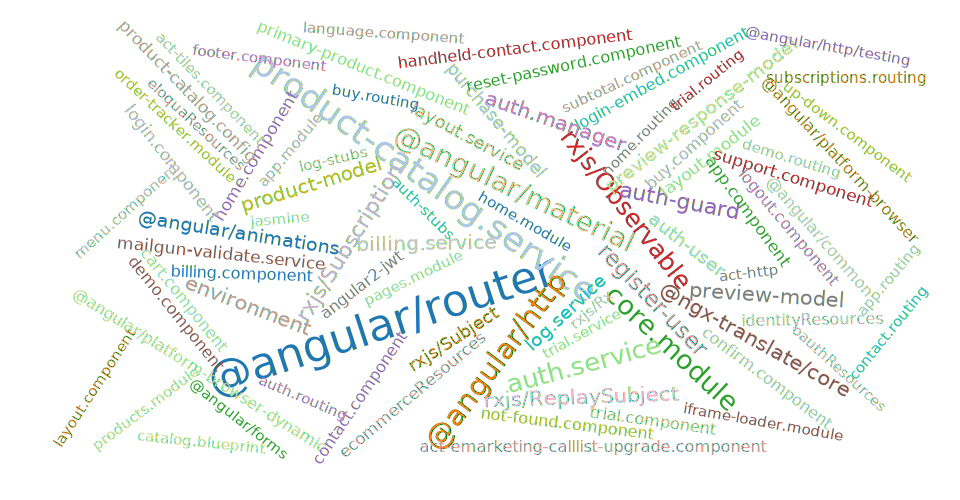

In [6]:
// TODO: create a gulp stream angular component out of it
// TODO: connect with gulp-git https://www.npmjs.com/package/gulp-git
// install https://github.com/Automattic/node-canvas/wiki/installation---osx
// install using brew install pkg-config fontconfig cairo pixman giflib libjpeg libpng
var path = require('path');

var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
var project = PROFILE_PATH + '/Documents/portal';

$$.async()
projectWordCloud(project)
    .then(svg => $$.svg(svg))
    .catch(e => $$.sendError(e));



Find similar filename in project?

In [ ]:
var findSimilarFile = (base, project) => {
    return new Promise((resolve, reject) => {
        var searchStrings = '**/' + base + '.(ts|js)';
        console.log('Search for ' + searchStrings);
        glob(searchStrings, {exclude: ['**/node_modules/**'], cwd: project}, function (err, matches) {
            var isEmpty = matches.length == 0;
            if(err) {
                return reject(err);
            } else if (isEmpty) {
                console.log('No matches for ' + searchStrings)
                return resolve();
            }

            // TODO: try to build and make sure it works before patching
            resolve(matches[0].replace('.ts', ''));
        });
    });
};
findSimilarFile;



In [ ]:
var importer = require('../Core');
var execSync = require('child_process').execSync;
try {
    require.resolve('glob');
    require.resolve('gulp');
    require.resolve('gulp-replace');
    require.resolve('gulp-tap');
} catch (e) {
    execSync('npm install glob "github:gulpjs/gulp.git#4.0" gulp-replace gulp-tap');
}
var fs = require('fs');
var path = require('path');
var glob = require('glob');
var gulp = require('gulp');
var tap = require('gulp-tap');
var replace = require('gulp-replace');

// list all broken references in modules?
var projectRelatives = (project) => {
    var missing, missingPackages;
    
    var fixRelative = (m) => {
        if(typeof m == 'undefined') {
            return;
        }
        var file = m.split('.ts/')[0] + '.ts';
        var fromPath = m.split('.ts/')[1].split('->')[0];
        var match = m.split('.ts/')[1].split('->')[1];
        var newRelative = path.relative(path.dirname(file), path.join(project, match));
        gulp.task('fix include', function() {
            var fixFile = path.relative(project, file);
            console.log('Replacing ' + fromPath + ' -> ' + newRelative + ' in ' + fixFile)
            return gulp.src(['**/' + fixFile], {cwd: project})
                .pipe(replace(fromPath, newRelative))
                .pipe(gulp.dest(project));
        });
        
        return tasksToPromise(['fix include'], []);
    };
    
    var uniqueArray = (arr) => arr.filter((value, index, array) => array.indexOf(value, index + 1) < 0);
    
    gulp.task('add packages', function () {
        var toAdd = '';
        return gulp.src('package.json', {cwd: project})
            .pipe(tap(file => {
                // TODO: resolve using existing package.json from another project?  This method of using the import isn't going to go far, how does NPM do this?
                // Possible to search for top two directories? @angular/material versus angular2-jwt versus zone.js/dist/zone
                var content = file.contents.toString();
                missingPackages.map(p => p.split('.ts/')[1].forEach(m => {
                    if(content.indexOf(m) == -1) {
                        toAdd += '"' + m + '": "latest",'
                    }
                });
                if(toAdd != '') {
                    console.log('Adding ' + toAdd);
                    file.contents = new Buffer(content.replace(/"dependencies"\s*:\s*\{/ig, (m) => m + toAdd));
                }
            }))
            .pipe(gulp.dest(project));
    });

    gulp.task('fix relative paths and includes', 
        gulp.series(
            importer.interpretAll([
                'relative paths and includes'
            ])
            .then(r => r[0].runInNEL({project}))
            .then(r => {
                console.log(r);
                {missing, missingPackages} = r;
            }),
            Promise.all(Object.keys(missing).map(k => findSimilarFile(k, project).then(f => {
                if(typeof f == 'undefined') {
                    return Promise.resolve();
                }
                return Promise.all(missing[k].map(m => fixRelative(m + '->' + f)));
            }))),
            'add packages'
        ));
    
    return gulp.series('fix relative paths and includes');
    // TODO: try building with all results resolved
    // TODO: create path and apply
};
projectRelatives;



De-lint notebook cells automatically?

Find too long of functions using regexp?
(?=\{((?:[^{}]++|\{(?1)\})++)\})

Export all notebooks to a structured folder where each cell has it's own file for linting?

Import files in to cells?

